The goal here is to calculate the fraction of the baseline footprint vs. BigWFD footprint that can be observed with northern facilities (-20$\leq$dec$\leq$20).  We look at the two footprints with and without an extinciton cut (needed for extragalactic science).

We also plot the distribution of the extinction in both footprint and print some statistics.

In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
import healpy as hp
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.maps as maps
import lsst.sims.maf.metricBundles as metricBundles

# need some routines developed for LSSTDESC/ObsStrat/
import sys
sys.path.insert(0, '/global/homes/a/awan/LSST/lsstRepos/ObsStrat/code/modifyWFD/')
import helpers

# lets just ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
fontsize = 16
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['legend.fontsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.titlesize'] = fontsize

**Set up**

In [3]:
fids_file = '../field_list.csv'   # in this repo

outdir = '/global/cscratch1/sd/awan/lsst_output/moar_area_output/'

# path to the baseline database. need for including ebv.
dbpath = '/global/cscratch1/sd/awan/dbs_wp_unzipped/baseline2018a.db'

**Read in the fields list**

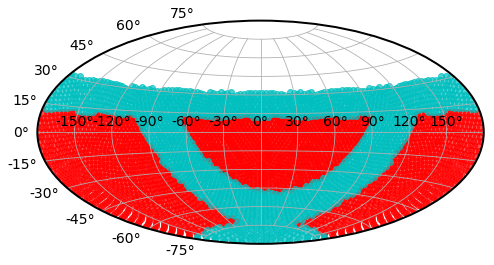

In [4]:
# Read the field list.
fields = pd.read_csv(fids_file)
# Select fields with declination between -90 and 32 -- our "big sky" footprint
bigsky = fields.query('(dec >= -90) and (dec <= 32)') 
wfd = fields.query('(dec >= -72.25) and (dec <= 12.4) and ((gb >= 15) or (gb <= -15))')
nonwfd = bigsky.query('((dec < -72.25) or (dec > 12.4)) or ((gb < 15) and (gb > -15))')

# Plot the fields so we can check what this footprint looks like.
def radec2project(ra, dec):
    return (np.radians(ra) - np.pi, np.radians(dec))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="aitoff")
x, y = radec2project(wfd.ra, wfd.dec)
ax.scatter(x, y, alpha=0.7, color='r')

x, y = radec2project(nonwfd.ra, nonwfd.dec)
ax.scatter(x, y, alpha=0.7, color='c')
plt.grid(True)
plt.show()

**Read in the mapping between fieldIds and HEALPix pixels (saved by get_fov_pixels)**

In [5]:
# read in the dictionary with keys=fid
file = 'pixels_in_fieldid_nside256.pickle'
print('Reading in %s:'%file)
nside = int(file.split('nside')[-1].split('.pickle')[0])
print('Nside: %s'%nside)
pix_fid_dict = pickle.load(open('%s%s'%(outdir, file), "rb"))

# -----------------------------------
# get the healpix pixels for all the fieldsIDs in BigWFD
pix_list = []
for fid in wfd.fieldId:
    pix_list += pix_fid_dict[fid]
pix_list = np.unique(pix_list)

# -----------------------------------
# save the pixel list
footprint_pixels = {}
footprint_pixels['BigWFD'] = pix_list

# get the healpix pixels for all the fieldsIDs in Big nonWFD
pix_list = []
for fid in nonwfd.fieldId:
    pix_list += pix_fid_dict[fid]
pix_list = np.unique(pix_list)

# save the pixel list
footprint_pixels['Big-nonWFD'] = pix_list

# -----------------------------------
# read in the dictionary with keys=pixels for later
file = 'fieldid_in_pixels_nside256.pickle'
print('Reading in %s:'%file)
nside = int(file.split('nside')[-1].split('.pickle')[0])
print('Nside: %s'%nside)
fid_pix_dict = pickle.load(open('%s/%s'%(outdir, file), "rb"))

Reading in pixels_in_fieldid_nside256.pickle:
Nside: 256
Reading in fieldid_in_pixels_nside256.pickle:
Nside: 256


**Read in the baseline2018a footprints**

In [6]:
# read in the pixels for all-band WFD 
file = 'baseline2018a_all-band_wfd_pixels_nside256.csv'
print('Reading %s'%file)
footprint_pixels['all-band baseline2018a WFD'] = pd.read_csv('%s/%s'%(outdir, file))['pixels'].values

# read in the pixels for any-band non-WFD
file = 'baseline2018a_any-band_nonwfd_nondd_pixels_nside256.csv'
print('Reading %s'%file)
footprint_pixels['any-band baseline2018a nonWFD, nonDD'] = pd.read_csv('%s/%s'%(outdir, file))['pixels'].values

Reading baseline2018a_all-band_wfd_pixels_nside256.csv
Reading baseline2018a_any-band_nonwfd_nondd_pixels_nside256.csv


**Construct an ebv to include extinction-limited statistics**

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


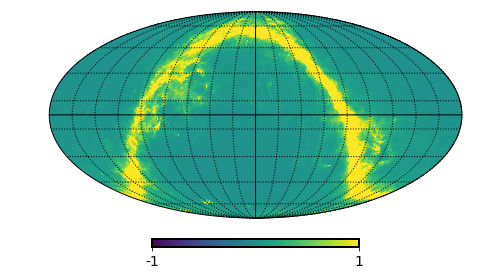

CPU times: user 30.4 s, sys: 2.58 s, total: 33 s
Wall time: 50.3 s


In [7]:
%%time
# import EBV map from MAF
opsdb = db.OpsimDatabase(dbpath)
simdata = opsdb.fetchMetricData(['fieldId', 'fieldRA', 'fieldDec', 'night'],
                                sqlconstraint=None)
slicer = slicers.HealpixSlicer(lonCol='fieldRA',
                               latCol='fieldDec',
                               latLonDeg=opsdb.raDecInDeg, nside=nside)
# set up dust map to get the ebv map
dustmap = maps.DustMap(nside=nside)
slicer.setupSlicer(simdata)
result = dustmap.run(slicer.slicePoints)
ebv_map = result['ebv']

# plot to see things
helpers.plot_skymap(ebv_map, cmin=-1, cmax=1)

**Lets plot the distribution of the extinction in both footprints. Also, lets calculate some statistics.**

## all-band baseline2018a WFD:
Percentile values: 25th, 50th, 75th: 0.03031, 0.06151, 0.13928
min: 0.00041 , max: 4.82265

## any-band baseline2018a nonWFD, nonDD:
Percentile values: 25th, 50th, 75th: 0.05031, 0.15597, 0.56593
min: 0.00958 , max: 17.64532

## BigWFD:
Percentile values: 25th, 50th, 75th: 0.02694, 0.04774, 0.08553
min: 0.00041 , max: 56.93126

## Big-nonWFD:
Percentile values: 25th, 50th, 75th: 0.06100, 0.17194, 0.49643
min: 0.00644 , max: 145.55341


## Saved bigwfd_vs_baseline2018a_ebv_histogram.png


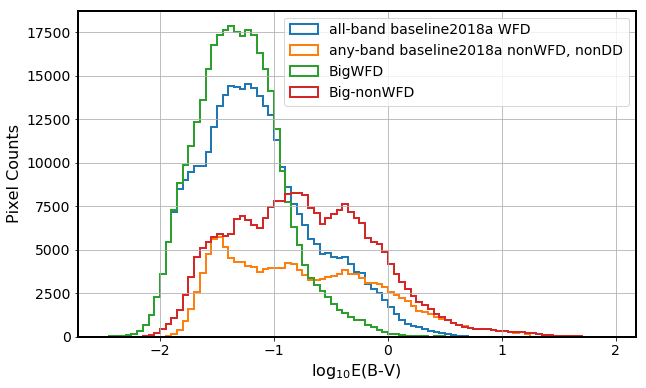

In [8]:
bins_ebv = np.arange(-2.5, 2, 0.05)
for key in ['all-band baseline2018a WFD', 'any-band baseline2018a nonWFD, nonDD', 'BigWFD', 'Big-nonWFD']:
    row = '## %s:\nPercentile values: '%key
    row += '25th, 50th, 75th: '
    for i, r in enumerate([25, 50, 75]):
        row += '%.5f'%(np.percentile(ebv_map[footprint_pixels[key]], r))
        if i<2:
            row += ', '
        else:
            row += '\n'
    row += 'min: %.5f , max: %.5f\n'%(min(ebv_map[footprint_pixels[key]]),
                                      max(ebv_map[footprint_pixels[key]]))
    print(row)
    plt.hist(np.log10(ebv_map[footprint_pixels[key]]), bins=bins_ebv, lw=2,
             histtype='step', label=key)
plt.xlabel('log$_{10}$E(B-V)')
plt.ylabel('Pixel Counts')
plt.legend()
# save figure
fname = 'bigwfd_vs_baseline2018a_ebv_histogram.png'
plt.savefig(filename='%s/%s'%(outdir, fname), format='png', bbox_inches='tight')
print('\n## Saved %s'%fname.split('/')[-1])
# show figure
plt.show()

**Find the area between -20<dec<20 with and without a limit on E(B-V)**

In [9]:
ebv_lim = 0.2
min_dec, max_dec = -20, 20
header = '| footprint | Total Area (deg2) |'
header += ' Area in %s$^{\circ}$ $\leq$ dec $\leq$ %s$^{\circ}$ (deg2) | '%(min_dec, max_dec)
header += ' Total Area with EBV<%s (deg2) | '%(ebv_lim)
header += ' Area in %s$^{\circ}$ $\leq$ dec $\leq$ %s$^{\circ}$ with EBV<%s (deg2) | '%(min_dec, max_dec, ebv_lim)
header2 = '| ------ | ------ | ------ | ------ | ------ |'

ebv_ind = np.where(ebv_map<0.2)[0]

rows = ''
# plot the ra, dec corresponding on the all-band pixels
for key in [f for f in footprint_pixels.keys() if not f.__contains__('DESI')]:
    ras, decs = helpers.pix_to_radec(pixels=footprint_pixels[key], nside=nside)
    
    ind_dec_limit = np.where((decs<=max_dec) & (decs>=min_dec))[0]
    # plot the ra, dec for clarity
    #plt.clf()
    #plt.scatter(ras, decs, )
    #plt.scatter(ras[ind_dec_limit], decs[ind_dec_limit], color='g', label='%s <= dec <= %s'%(min_dec, max_dec))
    #plt.title(key)
    #plt.xlabel('RA')
    #plt.ylabel('Dec')
    #plt.show()
    
    # lets get the total area and area of the region in the dec limits
    tot0 = helpers.get_area(footprint_pixels[key], nside)
    subsample0 = helpers.get_area(footprint_pixels[key][ind_dec_limit], nside)

    rows += '| %s | %.f | %.f '%(key, tot0, subsample0)
    
    # lets now focus on the pixels that have EVC<ebv_limit
    # ebv-limited ones in the total area
    ebv_pix = np.array(list(set(footprint_pixels[key]) - \
                            (set(footprint_pixels[key]) - set(ebv_ind))))
    tot = helpers.get_area(ebv_pix, nside)
    
    # ebv-limited ones in the dec-limited area
    ebv_pix = np.array(list(set(footprint_pixels[key][ind_dec_limit]) - \
                            (set(footprint_pixels[key][ind_dec_limit]) - set(ebv_ind))))
    subsample = helpers.get_area(ebv_pix, nside)
    
    rows += '| %.f (%.2f%% of all-total) | %.f |\n'%(tot, 100.*tot/tot0, subsample)
    
print('%s\n%s\n%s'%(header, header2, rows)) 

| footprint | Total Area (deg2) | Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ (deg2) |  Total Area with EBV<0.2 (deg2) |  Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ with EBV<0.2 (deg2) | 
| ------ | ------ | ------ | ------ | ------ |
| BigWFD | 18038 | 9277 | 16909 (93.74% of all-total) | 8396 |
| Big-nonWFD | 14019 | 5030 | 7566 (53.97% of all-total) | 2624 |
| all-band baseline2018a WFD | 18034 | 7789 | 14696 (81.49% of all-total) | 6265 |
| any-band baseline2018a nonWFD, nonDD | 8289 | 3638 | 4562 (55.04% of all-total) | 2175 |



| footprint | Total Area (deg2) | Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ (deg2) |  Total Area with EBV<0.2 (deg2) |  Area in -20$^{\circ}$ $\leq$ dec $\leq$ 20$^{\circ}$ with EBV<0.2 (deg2) | 
| ------ | ------ | ------ | ------ | ------ |
| BigWFD | 18038 | 9277 | 16909 (93.74% of all-total) | 8396 |
| Big-nonWFD | 14019 | 5030 | 7566 (53.97% of all-total) | 2624 |
| all-band baseline2018a WFD | 18034 | 7789 | 14696 (81.49% of all-total) | 6265 |
| any-band baseline2018a nonWFD, nonDD | 8289 | 3638 | 4562 (55.04% of all-total) | 2175 |

**Also, lets just look at overlap with dec > -20, since the BigSky non-WFD goes beyond +20 deg.**

In [10]:
ebv_lim = 0.2
min_dec = -20
header = '| footprint | Total Area (deg$^2$) |'
header += ' Area in %s$^{\circ} < $ dec (deg$^2$) | '%(min_dec)
header += ' Total Area with EBV<%s (deg$^2$) | '%(ebv_lim)
header += ' Area in %s$^{\circ} <$ dec with EBV<%s (deg$^2$) | '%(min_dec, ebv_lim)
header2 = '| ------ | ------ | ------ | ------ | ------ |'

ebv_ind = np.where(ebv_map<0.2)[0]

rows = ''
# plot the ra, dec corresponding on the all-band pixels
for key in [f for f in footprint_pixels.keys() if not f.__contains__('DESI')]:
    ras, decs = helpers.pix_to_radec(pixels=footprint_pixels[key], nside=nside)
    
    ind_dec_limit = np.where(decs>min_dec)[0]
    # plot the ra, dec for clarity
    #plt.clf()
    #plt.scatter(ras, decs, )
    #plt.scatter(ras[ind_dec_limit], decs[ind_dec_limit], color='g', label='%s <= dec <= %s'%(min_dec, max_dec))
    #plt.title(key)
    #plt.xlabel('RA')
    #plt.ylabel('Dec')
    #plt.show()
    
    # lets get the total area and area of the region in the dec limits
    tot0 = helpers.get_area(footprint_pixels[key], nside)
    subsample0 = helpers.get_area(footprint_pixels[key][ind_dec_limit], nside)

    rows += '| %s | %.f | %.f '%(key, tot0, subsample0)
    
    # lets now focus on the pixels that have EVC<ebv_limit
    # ebv-limited ones in the total area
    ebv_pix = np.array(list(set(footprint_pixels[key]) - \
                            (set(footprint_pixels[key]) - set(ebv_ind))))
    tot = helpers.get_area(ebv_pix, nside)
    
    # ebv-limited ones in the dec-limited area
    ebv_pix = np.array(list(set(footprint_pixels[key][ind_dec_limit]) - \
                            (set(footprint_pixels[key][ind_dec_limit]) - set(ebv_ind))))
    subsample = helpers.get_area(ebv_pix, nside)
    
    rows += '| %.f (%.2f%% of all-total) | %.f |\n'%(tot, 100.*tot/tot0, subsample)
    
print('%s\n%s\n%s'%(header, header2, rows)) 

| footprint | Total Area (deg$^2$) | Area in -20$^{\circ} < $ dec (deg$^2$) |  Total Area with EBV<0.2 (deg$^2$) |  Area in -20$^{\circ} <$ dec with EBV<0.2 (deg$^2$) | 
| ------ | ------ | ------ | ------ | ------ |
| BigWFD | 18038 | 9277 | 16909 (93.74% of all-total) | 8396 |
| Big-nonWFD | 14019 | 9078 | 7566 (53.97% of all-total) | 5772 |
| all-band baseline2018a WFD | 18034 | 7789 | 14696 (81.49% of all-total) | 6265 |
| any-band baseline2018a nonWFD, nonDD | 8289 | 4870 | 4562 (55.04% of all-total) | 2744 |



| footprint | Total Area (deg$^2$) | Area in -20$^{\circ} < $ dec (deg$^2$) |  Total Area with EBV<0.2 (deg$^2$) |  Area in -20$^{\circ} <$ dec with EBV<0.2 (deg$^2$) | 
| ------ | ------ | ------ | ------ | ------ |
| BigWFD | 18038 | 9277 | 16909 (93.74% of all-total) | 8396 |
| Big-nonWFD | 14019 | 9078 | 7566 (53.97% of all-total) | 5772 |
| all-band baseline2018a WFD | 18034 | 7789 | 14696 (81.49% of all-total) | 6265 |
| any-band baseline2018a nonWFD, nonDD | 8289 | 4870 | 4562 (55.04% of all-total) | 2744 |